In [1]:
# Preamble
import pandas as pd
import numpy as np
import os # To set our working folder
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen as uReq
import urllib.error as uErr
import re
import tenacity
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mticker
import seaborn as sns
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
from linearmodels.panel import PanelOLS
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate

if os.name=='nt':
    import xlwings as xw


@tenacity.retry(wait=tenacity.wait_exponential(multiplier=1, min=4, max=64), stop=tenacity.stop_after_attempt(5))
def get_that_page(url):
    try:
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        uClient = uReq(req)
        print('Success')
    except Exception:
        print('Trying again.')
    return uClient


def do_table(url):
    uClient = get_that_page(url)
    soup = BeautifulSoup(uClient, 'lxml')
    table = soup.find('table', class_='instruments-table')
    table_headers =[]
    for tx in soup.find_all('th'):
        table_headers.append(tx.get('id'))

    filler = ['unknown', 'pct']
    data = []
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        #print(cols)
        if len(cols)>0:
            data.append(cols)
    df = pd.DataFrame(data, columns=[x if x!=None else filler.pop() for x in table_headers])
    lyst = ['price', 'volume', 'value', 'outstanding_capitalisation', 'market_capitalisation', 'pct', 'trade_count']
    df[lyst] = df[lyst].replace({'\$': '', ',': ''}, regex=True).apply(pd.to_numeric,  errors='coerce')
    df['green_bond']= df['green_bond'].map({'false': 0, 'true': 1})
    df = df[~df['company'].str.contains('Smartshares')]
    df['code'] = df['code']+".NZ"
    nzx = df['code'].to_list()

    return(df[df['market_capitalisation']>0], nzx)


def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)


def nice_print(df, k=1, name=""):
    if isinstance(df, pd.DataFrame):
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))
    elif isinstance(df, pd.Series):
        df.name= name
        df=df.to_frame()
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))


dfm, nzx  = do_table('https://www.nzx.com/markets/NZSX')

Success


In [2]:
def returns(nzx, start, end):
    dfy = yf.download(nzx, start, end, progress=True, interval="1mo")
    df_close = dfy['Adj Close'].copy()
    df_close.dropna(how = 'all', inplace=True, axis = 1)
    df_close.sort_index(inplace=True)
    #df_close.dropna(how='all').pct_change().add(1).cumprod().mean(axis=1).sub(1).plot()
    df_close.index = pd.to_datetime(df_close.index, format ='%Y-%m-%d')
    df_close.columns = [re.sub(r'.NZ$|\^', "", x) for x in list(df_close)]
    return list(df_close), df_close.resample('M').last()

nzx_set, df_close = returns(nzx+['^NZ50'], '2011-10-01', '2022-04-30')

[*********************100%***********************]  153 of 153 completed

9 Failed downloads:
- AKL.NZ: No data found, symbol may be delisted
- KFLWG.NZ: No data found, symbol may be delisted
- BIF.NZ: No data found for this date range, symbol may be delisted
- MLNWE.NZ: No data found, symbol may be delisted
- PLP.NZ: No data found for this date range, symbol may be delisted
- CO2.NZ: No data found for this date range, symbol may be delisted
- NTLOB.NZ: No data found, symbol may be delisted
- BIT.NZ: No data found for this date range, symbol may be delisted
- FCT.NZ: No data found for this date range, symbol may be delisted


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

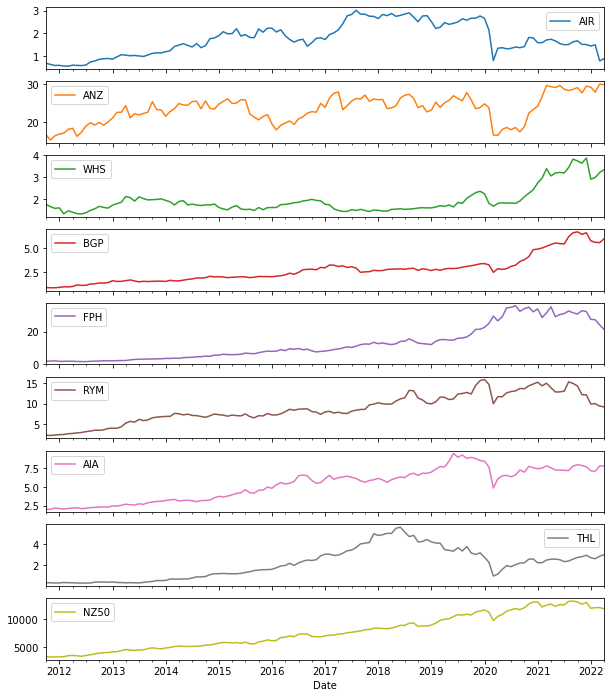

In [3]:
stocks_list = ["AIR", "ANZ", 'WHS', 'BGP', 'FPH', 'RYM', 'AIA', 'THL', 'NZ50']  # tickers seperated by space
data = df_close[stocks_list]
data.plot(figsize=(10, 12), subplots=True)

<AxesSubplot:xlabel='Date'>

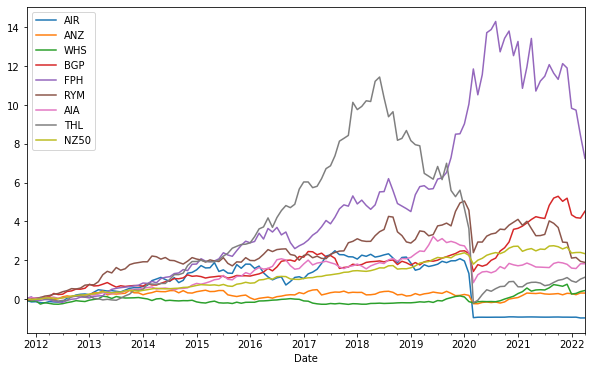

In [4]:
# Calculate monthly returns
monthly_ret = np.log(data).diff().dropna()
monthly_ret.add(1).cumprod().sub(1).plot(figsize=(10, 6))

In [5]:
def prelim_tables(df):
    df = df.copy()
    df['year'] = df.index.year.astype(int)
    df.set_index('year', append=True, inplace=True)
    print('Returns by year')
    nice_print(df.add(1).groupby('year').prod().sub(1), 100)
    #df.add(1).groupby('year').prod().sub(1).plot(subplots=True,  figsize=(10,20), kind='bar')
    
prelim_tables(monthly_ret) 

Returns by year
╒════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   year │      AIR │      ANZ │      WHS │      BGP │      FPH │      RYM │      AIA │      THL │    NZ50 │
╞════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│   2011 │ -14.8215 │  -2.0953 │ -10.6374 │  -3.6367 │  11.2563 │   1.3519 │   7.3383 │  -5.1515 │ -1.7537 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────┤
│   2012 │  47.9853 │  19.6986 │  -2.4437 │  61.3581 │  -1.4743 │  69.2617 │   6.2533 │  16.4118 │ 23.5295 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────┤
│   2013 │  25.3922 │  12.3514 │  23.6134 │   8.5986 │  56.3124 │  67.8698 │  31.7984 │  30.8689 │ 15.8919 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────┤
│  

In [6]:
# Mean Returns
mean_ret = monthly_ret.mean()
mean_ret.name = 'Mean Monthly Return'

sigma    = monthly_ret.std()
sigma.name = 'Sigma'

<AxesSubplot:>

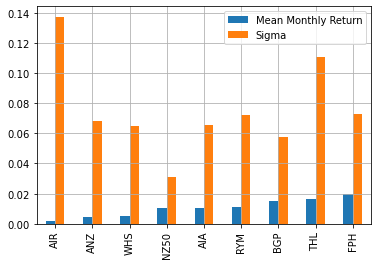

In [7]:
mean_ret.to_frame().join(sigma.to_frame()).sort_values(by=['Mean Monthly Return']).plot(kind='bar', grid=True)

╒══════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════╤═════════╤═════════╤════════╕
│      │     AIR │     ANZ │     WHS │     BGP │     FPH │    RYM │     AIA │     THL │   NZ50 │
╞══════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════╪═════════╪═════════╪════════╡
│ AIR  │  0.0189 │  0.0033 │  0.0016 │  0.0037 │ -0.0006 │ 0.0049 │  0.0048 │  0.0082 │ 0.0022 │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┼─────────┼─────────┼────────┤
│ ANZ  │  0.0033 │  0.0046 │  0.0009 │  0.0012 │ -0.0002 │ 0.0016 │  0.0018 │  0.0030 │ 0.0010 │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┼─────────┼─────────┼────────┤
│ WHS  │  0.0016 │  0.0009 │  0.0042 │  0.0011 │ -0.0002 │ 0.0018 │  0.0011 │  0.0013 │ 0.0007 │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┼─────────┼─────────┼────────┤
│ BGP  │  0.0037 │  0.0012 │  0.0011 │  0.0033 │ -0.0007 │ 0.0019 │  0.0018 │  0.0030 │ 0.0007 │
├──────┼─────────┼─────────┼──

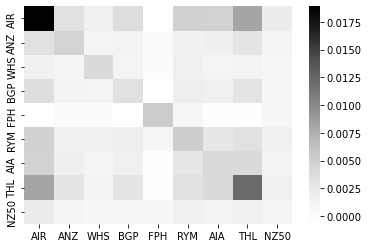

In [8]:
# Variance Covariance Matrix
cov_mat  = monthly_ret.cov()
sns.heatmap(cov_mat, cmap="Greys")
nice_print(cov_mat, 1, 'Covariances')

╒══════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════╤═════════╤═════════╤════════╕
│      │     AIR │     ANZ │     WHS │     BGP │     FPH │    RYM │     AIA │     THL │   NZ50 │
╞══════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════╪═════════╪═════════╪════════╡
│ AIR  │  1.0000 │  0.3538 │  0.1831 │  0.4688 │ -0.0626 │ 0.4929 │  0.5397 │  0.5381 │ 0.5073 │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┼─────────┼─────────┼────────┤
│ ANZ  │  0.3538 │  1.0000 │  0.2104 │  0.3125 │ -0.0380 │ 0.3175 │  0.4136 │  0.4039 │ 0.4788 │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┼─────────┼─────────┼────────┤
│ WHS  │  0.1831 │  0.2104 │  1.0000 │  0.3049 │ -0.0474 │ 0.3742 │  0.2543 │  0.1863 │ 0.3719 │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┼─────────┼─────────┼────────┤
│ BGP  │  0.4688 │  0.3125 │  0.3049 │  1.0000 │ -0.1644 │ 0.4561 │  0.4690 │  0.4680 │ 0.4188 │
├──────┼─────────┼─────────┼──

<AxesSubplot:>

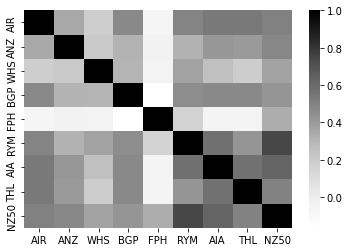

In [9]:
# Correlation Matrix
corr_mat = monthly_ret.corr()
nice_print(corr_mat, 1)
sns.heatmap(corr_mat, cmap="Greys")

In [10]:
# Regression
results = smf.ols('RYM ~ 1 + ANZ', data=monthly_ret).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    RYM   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     13.90
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000292
Time:                        12:26:18   Log-Likelihood:                 159.28
No. Observations:                 126   AIC:                            -314.6
Df Residuals:                     124   BIC:                            -308.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0097      0.006      1.579      0.1

In [13]:
#Scatter Plot

def scattplot(X, Y, monthly_ret):
    results = smf.ols(Y + ' ~ 1 + ' + X, data=monthly_ret).fit()
    
    fig = plt.figure(figsize=(7,6))
    ax = sns.regplot(x=X, y=Y, data=monthly_ret, scatter_kws={'s':5})
    
    set_xmargin(ax, left=0, right=0)
    
    # Titles and axes names
    ax.set_title(r'Monthly Returns')
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    plt.grid(linestyle="dotted", color='grey')
    
    # Equation
    plusmin = '-' if results.params.Intercept<0 else '+'
    equation = f'${{{Y}}}$ =  {results.params[1]:.3f} ${{{X}}}$ {plusmin} {abs(results.params.Intercept):.3f}'
    ax.text(y = monthly_ret[Y].max(), x = monthly_ret[X].min(), s = equation)
    plt.show()
    print(results.summary())
    return

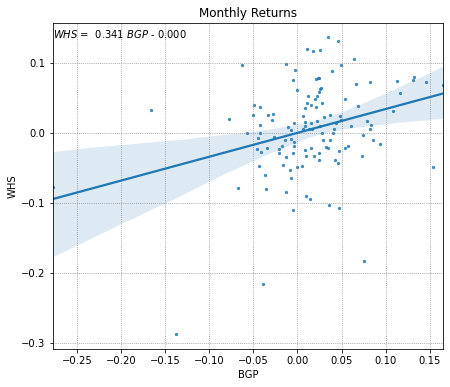

                            OLS Regression Results                            
Dep. Variable:                    WHS   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     12.70
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000519
Time:                        12:28:14   Log-Likelihood:                 172.92
No. Observations:                 126   AIC:                            -341.8
Df Residuals:                     124   BIC:                            -336.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.006     -0.029      0.9

In [12]:
scattplot('BGP','WHS', monthly_ret)

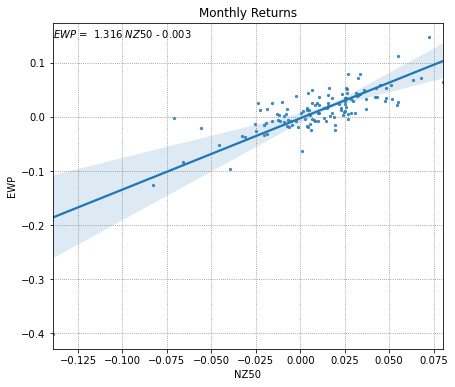

                            OLS Regression Results                            
Dep. Variable:                    EWP   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     204.6
Date:                Wed, 04 May 2022   Prob (F-statistic):           5.22e-28
Time:                        12:29:25   Log-Likelihood:                 256.93
No. Observations:                 126   AIC:                            -509.9
Df Residuals:                     124   BIC:                            -504.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0026      0.003     -0.882      0.3

In [15]:
# Equally weigthed portfolio
scattplot('NZ50','EWP', monthly_ret.assign(EWP = monthly_ret[[x for x in list(monthly_ret) if x!="NZ50"]].mean(axis=1)))